<a href="https://colab.research.google.com/github/pythonuzgit/Computer-vision-in-Medical-imaging/blob/main/Computer-vision-in-Medical-imaging%20/Computer_Vision_Chest_X_Ray_Dataset_categories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip '/content/chest-x-ray-dataset-4-categories.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Chest X_Ray Dataset/NORMAL/NORMAL2-IM-1350-0001.jpeg  
  inflating: Chest X_Ray Dataset/NORMAL/NORMAL2-IM-1351-0001.jpeg  
  inflating: Chest X_Ray Dataset/NORMAL/NORMAL2-IM-1356-0001.jpeg  
  inflating: Chest X_Ray Dataset/NORMAL/NORMAL2-IM-1357-0001.jpeg  
  inflating: Chest X_Ray Dataset/NORMAL/NORMAL2-IM-1360-0001.jpeg  
  inflating: Chest X_Ray Dataset/NORMAL/NORMAL2-IM-1362-0001.jpeg  
  inflating: Chest X_Ray Dataset/NORMAL/NORMAL2-IM-1365-0001.jpeg  
  inflating: Chest X_Ray Dataset/NORMAL/NORMAL2-IM-1371-0001.jpeg  
  inflating: Chest X_Ray Dataset/NORMAL/NORMAL2-IM-1376-0001.jpeg  
  inflating: Chest X_Ray Dataset/NORMAL/NORMAL2-IM-1379-0001.jpeg  
  inflating: Chest X_Ray Dataset/NORMAL/NORMAL2-IM-1385-0001.jpeg  
  inflating: Chest X_Ray Dataset/NORMAL/NORMAL2-IM-1396-0001.jpeg  
  inflating: Chest X_Ray Dataset/NORMAL/NORMAL2-IM-1400-0001.jpeg  
  inflating: Chest X_Ray Dataset/NORMAL/NORMAL2-IM-1401-0001.jpeg

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

Set Up Data Path

In [ ]:
dataset_path = '/content/Chest X_Ray Dataset'

In [ ]:
subfolders = [f.name for f in os.scandir(dataset_path) if f.is_dir()]
print("Subfolders (types):", subfolders)

Subfolders (types): ['COVID19', 'PNEUMONIA', 'NORMAL', 'TURBERCULOSIS']


Data Preprocessing

In [ ]:
image_counts = {}

for subfolder in subfolders:
    folder_path = os.path.join(dataset_path, subfolder)
    num_images = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    image_counts[subfolder] = num_images

Create a dataset from a Pandas DataFrame

In [ ]:
df = pd.DataFrame(list(image_counts.items()), columns=['Type', 'Image Count'])

In [ ]:
df

,Type,Image Count
0,COVID19,576
1,PNEUMONIA,4273
2,NORMAL,1583
3,TURBERCULOSIS,700


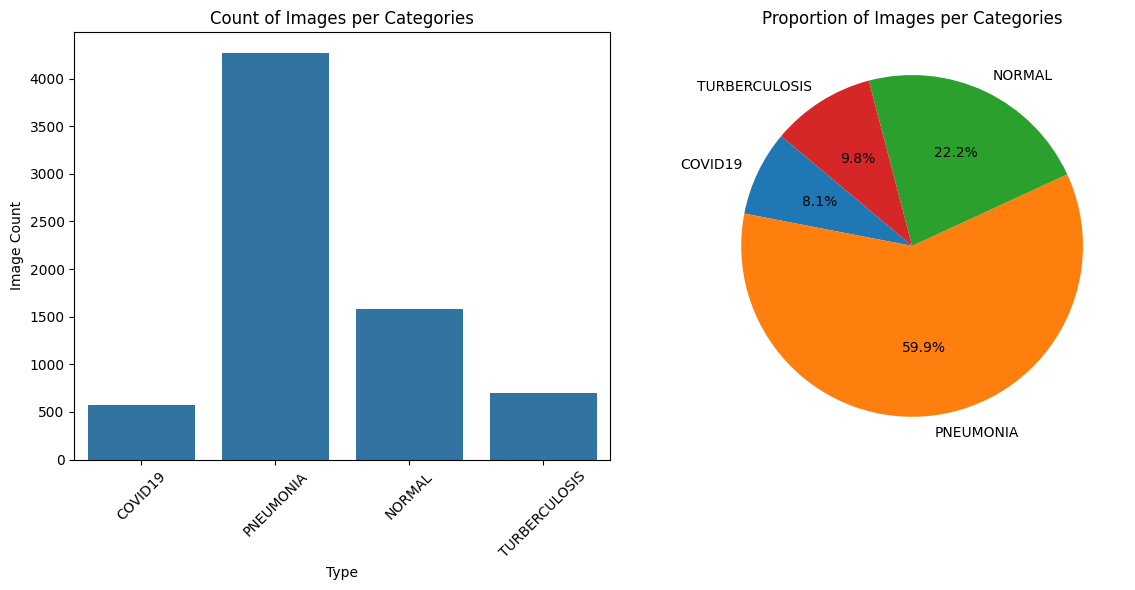

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Type', y='Image Count', data=df)
plt.title('Count of Images per Categories')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(df['Image Count'], labels=df['Type'], autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Images per Categories')

plt.tight_layout()
plt.show()

Import the necessary module from the Python Imaging Library

In [ ]:
from PIL import Image

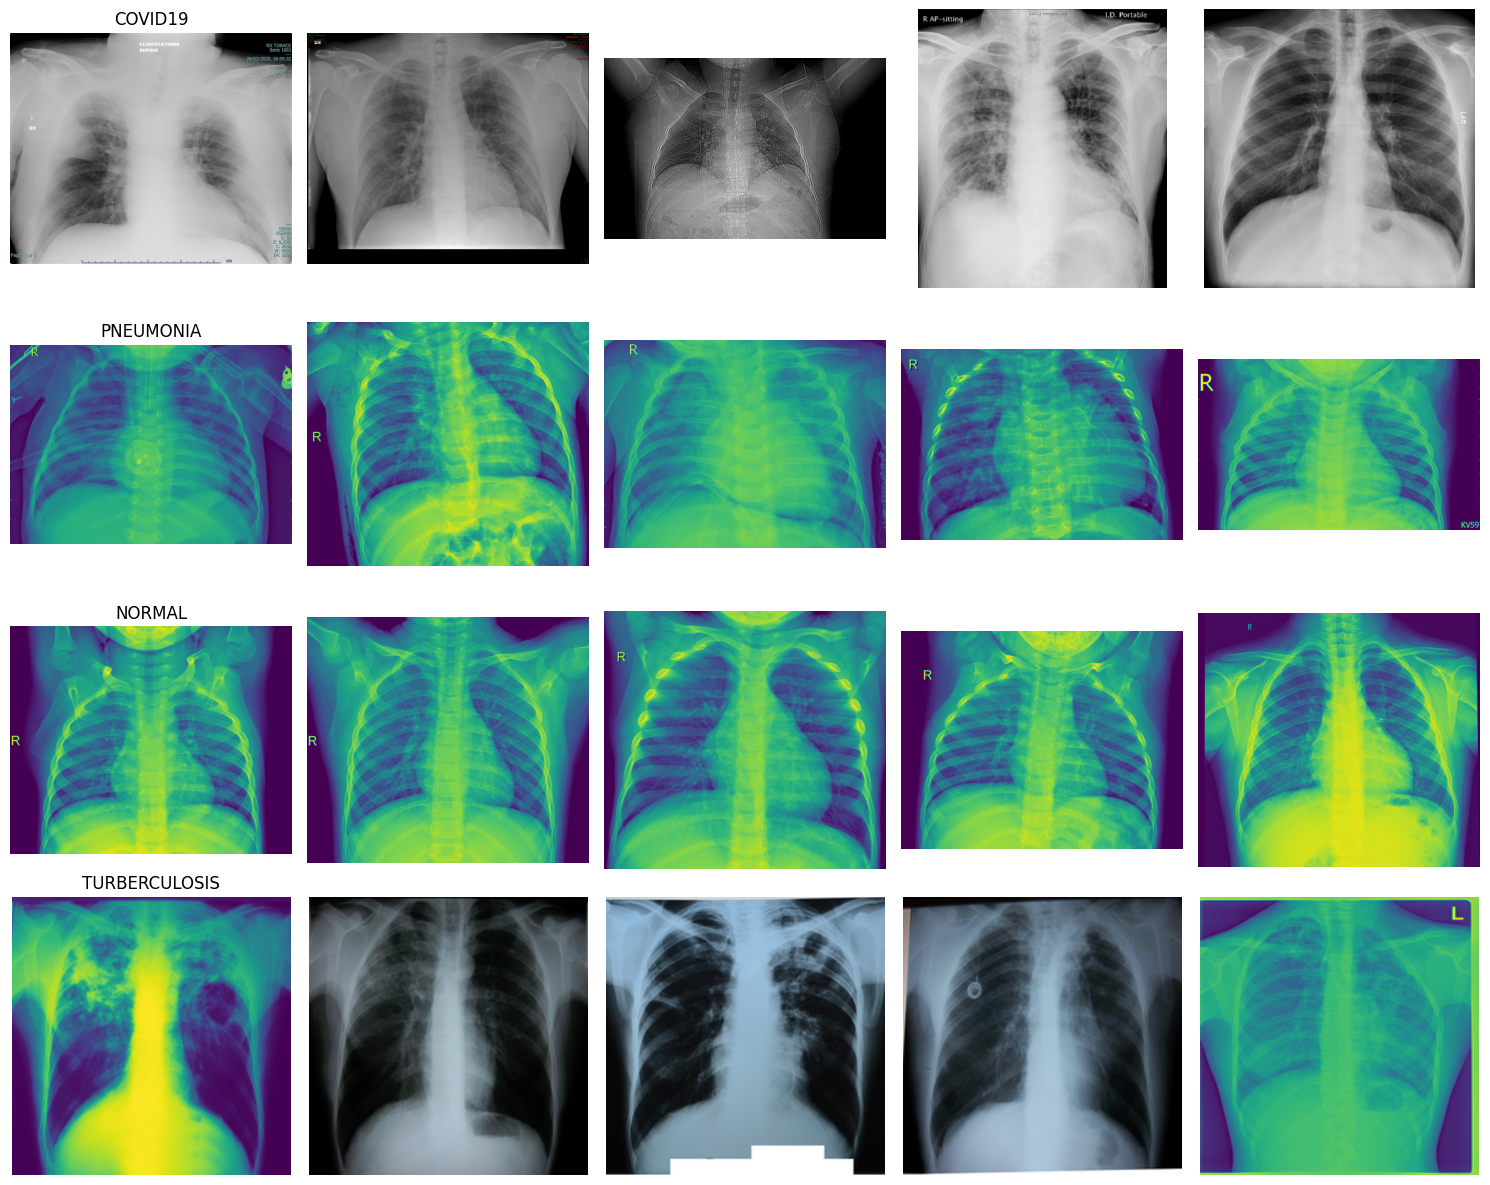

In [ ]:
def display_images_from_folders(dataset_path, subfolders, num_images=5):
    fig, axs = plt.subplots(len(subfolders), num_images, figsize=(15, 3 * len(subfolders)))

    for i, subfolder in enumerate(subfolders):
        folder_path = os.path.join(dataset_path, subfolder)
        images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

        for j in range(min(num_images, len(images))):
            img_path = os.path.join(folder_path, images[j])
            img = Image.open(img_path)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_title(subfolder, fontsize=12)

    plt.tight_layout()
    plt.show()

display_images_from_folders(dataset_path, subfolders, num_images=5)

In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())

Num GPUs Available:  0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [ ]:
img_height, img_width = 224, 224
batch_size = 32
epochs = 10

Split the Dataset

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 5707 images belonging to 4 classes.
Found 1425 images belonging to 4 classes.


Fine-tuning

In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Build the Model

In [ ]:
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Train the Model

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 513s 3s/step - accuracy: 0.8640 - loss: 0.3567 - val_accuracy: 0.9516 - val_loss: 0.1381
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 449s 2s/step - accuracy: 0.9554 - loss: 0.1260 - val_accuracy: 0.9544 - val_loss: 0.1261
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - accuracy: 0.9605 - loss: 0.1052 - val_accuracy: 0.9579 - val_loss: 0.1357
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 509s 3s/step - accuracy: 0.9682 - loss: 0.0935 - val_accuracy: 0.9544 - val_loss: 0.1253
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 515s 3s/step - accuracy: 0.9804 - loss: 0.0651 - val_accuracy: 0.9551 - val_loss: 0.1209
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 506s 3s/step - accuracy: 0.9752 - loss: 0.0680 - val_accuracy: 0.9579 - val_loss: 0.1187
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 513s 3s/step - accuracy: 0.9788 - loss: 0.0615 - val_accuracy: 0.9593 - val_loss: 0.1146
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.9831 - loss: 0.0466 - val_accuracy: 0.957

Checking Accuracy Of Model

In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

45/45 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9498 - loss: 0.1347
Validation Accuracy: 95.09%


Plotting Results

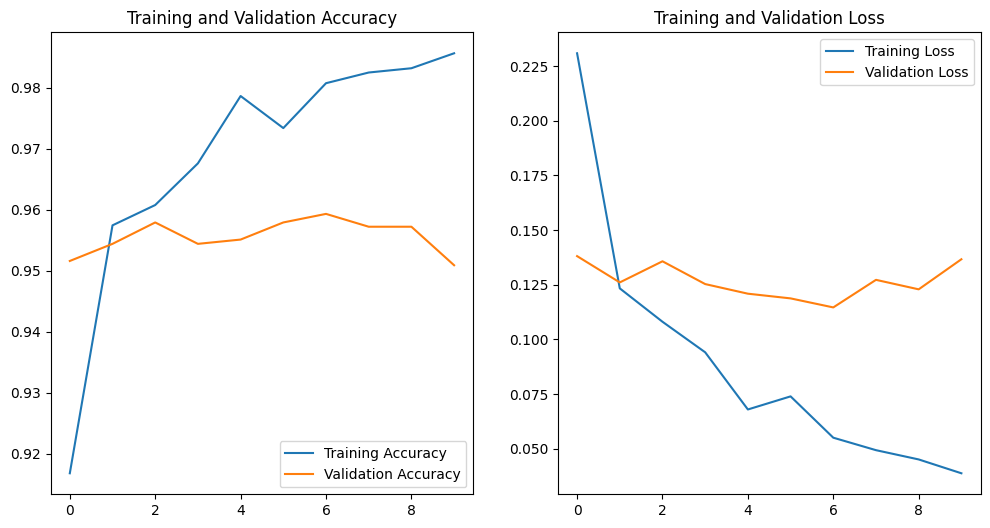

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()